# Annual Averaging and Fitting a Trend Line

### Authors

Fletcher Hozven fhozven@ucsb.edu

Samantha Stevenson sstevenson@ucsb.edu


### Table of Contents

[Goals](#purpose)

[Import Packages](#Import)

[Isolate the Desired Time](#time)

[Choose the Variable from our Data](#variable)

[Define Specific Region](#Region)

[Spatial Average Over the Selected Region](#spatial)

[Calculate the Annual Mean Temperature](#annual)

[Convert Temperatures to Celsius](#Celsius)

[Calculate Line of Best Fit](#Best)

[Plot!](#Plot)

<a id='purpose'></a> 
## **Goals**

For this tutorial we will be using data from the Coupled Model Intercomparison Project phase 6 (CMIP6) to construct a  time series plot of the annually averaged air surface temperature in New York City. If you have already worked through tutorial 1. "Read in Climate Data + Plotting a Time Series" in this repo, some of the content is similar - the main differences here are: 
- _Annual averages_ of temperature are computed using the `groupby` function, prior to plotting the time series.
- A _line of best fit_ is calculated using `np.polyfit1d`, which shows the slope of the linear trend in the time series.

This tutorial assumes that you have the cftime, xarray, matplotlib, and numpy packages installed and that you can open and read a netCDF file in xarray. If you have not covered these steps yet, see tutorial 1 for details on using `conda install` to install new packages and the xarray `open_dataset()` function to open netCDF files.

<a id='Import'></a> 
## **Import Packages**

Here the necessary packages for our time series graph are already installed on our local machine, let's quickly import them:¶

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

What are we installing and importing exactly?
- `xarray` can read and write NetCDF files
- `matplotlib` is a plotting library that will be used to plot maps and geospatial data
- `numpy` is used for working with arrays and will help us create our line of best fit

<a id='Inspect'></a> 
## **Inspect Data**
Here we are examining a file on a local machine, which was downloaded from the [Earth System Grid Federation (ESGF) MetaGrid website](https://aims2.llnl.gov/search). 

For details on how to find a file of interest, see our [Data Download: Web](https://climate-datalab.org/data-download-from-web/) tutorial.

Next, wee’ll use the `xr.open_dataset()` function from xarray to open the NetCDF file. This function reads the file and loads it into an xarray.Dataset object and allows for easy manipulation and analysis of the data.

Here we will use the same dataset that was used in tutorial 1 "Read in Climate Data":

In [2]:
data = xr.open_dataset('/Users/samstevenson/Box Sync/Climate_DataLab/tas_Amon_CanESM5_historical_r10i1p1f1_gn_185001-201412.nc')

Use the `print()` function to display the contents of the xarray dataset, which we have named "data":

In [3]:
print(data)

<xarray.Dataset>
Dimensions:    (time: 1980, bnds: 2, lat: 64, lon: 128)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
Attributes: (12/53)
    CCCma_model_hash:            55f484f90aff0e32c5a8e92a42c6b9ae7ffe6224
    CCCma_parent_runid:          rc3.1-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-his10
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    tracking_id:                 hdl:21.14100/5ed65f

__We print the dataset because it...__
- Provides a clear picture of what the data looks like and what we have to work with
- Allows us to verify that the necessary variables (e.g., `tas` for air surface temperature) are present in the dataset
- Checks if the dataset covers the required time range and geographical region

#### _HINT- if you ever need to find a file path name, you can do this quickly by dragging the file from your navigation window (Windows Explorer/Finder) into the terminal window (Windows Command Prompt/Terminal)._
- ##### The terminal will spit out the name of where to find the file
- ##### Copy and paste that name in xr.open_dataset to open the file !!

<a id='time'></a> 
## **Isolate the Desired Time** 
The dataset might cover a broad time range - this can vary from simulation to simulation. Printing the data helps identify the range of times included in your file; in this case, the time ranges from 1850-01-16 to 2014-12-16. For this example we want to focus on a specific period, from 1910 to 2010. To restrict the xarray Dataset object to include only these years, we can combine the `sel` and `slice` commands:

In [4]:
data = data.sel(time=slice('1910-01-01','2010-12-31'))

The `sel()` function is used to select data along one or more dimensions—in this case, the time dimension.

By passing the `slice()` function with specific start and end dates, '1910-01-01' and '2010-12-31', the dataset is filtered to only include data within Jan 1st 1910 to December 31st 2010.

<a id='Region'></a> 
## **Define Specific Region** 

#### __Let's choose New York City!__

A) Define the latitude and longitude bounds for New York City¶
- This code snippet is setting up two pairs of variables, `lat_min` and `lat_max` for latitude, and `lon_min` and `lon_max` for longitude.
- These variables are used to define a specific geographic region of interest within a broader dataset
- You can use a map or a globe to determine the approximate latitude and longitude boundaries of the region you're interested in.
- For instance:
    - The latitude range of 40.5°N to 41.0°N is a small range over New York City
    - The longitude range of 285.5° to 286.5° covers the area around New York City
    
To make things easier, we'll also select only the "tas" variable from the xarray Dataset. This step is optional, but can make it slightly easier to plot (if you do NOT include this step, you'll have to add `data.tas` rather than `data` in your plot commands below). 

In [5]:
# Select tas variable, store as xarray DataArray
tas = data['tas']

# Define min/max bounds for region of interest (NYC)
lat_min, lat_max = 40, 41.5
lon_min, lon_max = 285.5, 287

B) Subset the Data for New York City
- The code defines latitude and longitude masks for New York City using the `tas` DataArray.
- The masks (`tas_NYC_lat` and `tas_NYC_lon`) filter the dataset to include only the grid cells within the specified latitude (`lat_min` to `lat_max`) and longitude (`lon_min` to `lon_max`) boundaries.
- Finally, the `tas.where()` function is used to subset the data to the specified region, dropping any data points outside the specified latitude and longitude range.

In [6]:
# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
tas_NYC_lat = (tas.lat >= lat_min) & (tas.lat <= lat_max)
tas_NYC_lon = (tas.lon >= lon_min) & (tas.lon <= lon_max)

# Find points where the mask value is True, drop all other points
tas_NYC = tas.where(tas_NYC_lat & tas_NYC_lon, drop=True)

<a id='spatial'></a> 
## **Spatial Average Over the Selected Region**

The code block below computes the average temperature for NYC over time, with the latitude and longitude dimensions removed.

In [7]:
tas_NYC = tas_NYC.mean(dim=['lat','lon'])

Breaking down the line of code above:

- `tas_NYC` filtered temperature data for New York City.
- `.mean(dim=['lat', 'lon'])`Averages the temperature data over all the latitude and longitude points in the NYC region that was defined in the previous step
- The result is a single average temperature value for each time step, rather than multiple values for different locations.

<a id='annual'></a> 
## **Calculate the Annual Mean Temperature**
Here we want to now calculate the average annual temperature for New York City. This can be accomplished using xarray's ["groupby"](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.groupby.html) functionality: groupby creates groups within an xarray Dataset or DataArray, which track the data according to the group category you define. In this case, we'll be building groups based on each year within the dataset!

It's important to understand that groupby does NOT calculate the average itself - it just builds the groups. So to get the annual averages, you then need to actually calculate the average over each group. This is done using the `.mean()` command below; see the breakdown of the below command:

- `tas_NYC` is the temperature data averaged over latitude and longitude.
- `.groupby('time.year')` Groups the data by each year.
- `.mean()` Computes the mean temperature for each year.
- The `annual_mean` variable now holds the average global temperature for each year, which can be used to observe long-term trends.

In [8]:
annual_mean = tas_NYC.groupby('time.year').mean()

<a id='Celsius'></a> 
## **Convert Temperatures to Celsius**
- Temperature data in climate studies is often stored in Kelvin, but Celsius is more commonly used and easier to interpret for most people.
- To convert from Kelvin to Celsius, subtract 273.15 from the temperature values. This conversion is applied to the annual mean 

In [9]:
annual_mean = annual_mean - 273.15

<a id='Best'></a> 
## **Calculate Line of Best Fit**

A line of best fit is used to show the relationship between data points, and to predict future data based on the line's slope. This will show the overall trend of our air surface temperature graph and see whether the temp increases or decreases over time. We will do this using `np.polyfit`, which is a function in NumPy that fits a polynomial of a specified degree to a set of data points. It uses the least squares method to find the best-fitting line for the `annual_mean.year` x-axis and `annual_mean` temperature y-axis.

In the below code block, the x-axis data is specified as year (`annual_mean.year`), and the y-axis data as the temperature (`annual_mean`). The `1` is the order of the polynomial: in this case, we want to fit a straight line. A higher number would indicate fitting a higher-order polynomial.

The output returned by np.polyfit is the best-fit parameters for the linear polynomial fit to the temperature data. We then want to create x and y values corresponding to that line of best fit, in order to add it to the plot: the `np.poly1d` function builds us a polynomial "object", which we can then evaluate at the x values we want to get the corresponding y values for the line of best fit. See [the np.poly1d manual](https://numpy.org/doc/stable/reference/generated/numpy.poly1d.html) for more details!

In [10]:
# Calculate best-fit parameters for the linear polynomial fit of temperature to year
x = np.polyfit(annual_mean.year, annual_mean, 1)

# Generate a polynomial object using those best-fit parameters
trend_line = np.poly1d(x)  

<a id='Plot'></a> 
## **Plot!**
We can now plot the regional average surface air temperature for New York City from 1910 to 2010, to see how temperatures have changed over time

A) Set Up the Plot:
- Start by creating a figure and axis using `plt.subplots()`.
- This function creates a figure (`fig`) and a set of subplots (`ax`).
- The figure is the overall window or page that contains the plot, while the axes are the actual plotting areas where the data will be visualized.
- `figsize=(14, 7)` specifies the size of the figure in inches, setting up the space where your data will be plotted.

B) Plot Annual Temperatures:
- The following code creates a line graph showing how the regional average surface air temperature for NYC changes year by year from 1910 to 2010.
- `ax.plot()`: This function plots the data on the specified axes, creating a line graph by connecting data points with straight lines.
- `annual_mean.year`: This represents the data for the x-axis, showing the years from 1910 to 2010. The year is extracted automatically from the time dimension of the `tas` dataset.
- `annual_mean`: This represents the data for the y-axis, showing the average surface air temperature in Celsius for each year for the NYC region.
- `label='Annual Avg Temperature (NYC)'`: The label argument is used for the legend, identifying what this line represents.
- `color='blue'`: This sets the color of the line to blue, a common choice for temperature data in visualizations.

C) Plot Line of Best Fit / Trend Line:
- The following code creates a line of best fit to show the overall trend of the temperature data
- This also uses the function `ax.plot()` and x-axis data `annual_mean.year` to create a line graph with year data as its x-axis
- `trend_line`is the function that calculates the corresponding y-value (temperature) of the line of best fit given the year.
- `color='red'`This sets the line color to red.
- `linestyle='--'`: This makes the line dashed, which is commonly used for trend lines.
- `label=f'Trend Line(Slope = {x[0]:.4f}°C/year)'`Adds a label to the legend, showing the line of best fit with the slope value rounded to 4 decimal places.
  
D) Add Labels, Title, and Legend:
- Use `ax.set_title()`, `ax.set_xlabel()`, and `ax.set_ylabel()` to add a title and labels to your plot, making it more informative.
- Finally, `ax.legend()` adds a legend to differentiate between the plotted lines.

E) Show the Plot!
- The last step! `plt.show()` renders the plot, opening a window (or displaying inline, depending on your environment) to show the final visualization.


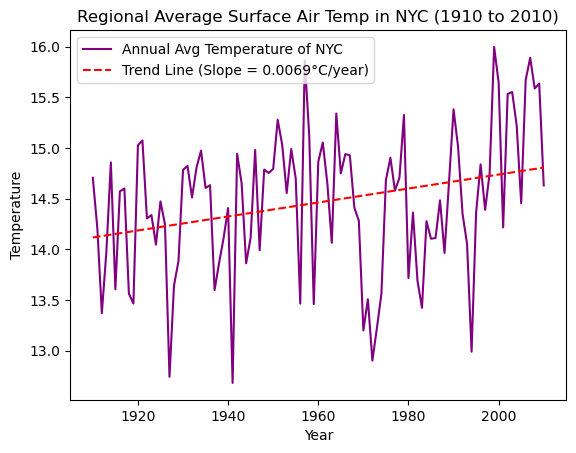

In [11]:
fig, ax = plt.subplots()
ax.plot(annual_mean.year, annual_mean, label= 'Annual Avg Temperature of NYC', color='purple')
ax.plot(annual_mean.year, trend_line(annual_mean.year), color='red', linestyle='--', label=f'Trend Line (Slope = {x[0]:.4f}°C/year)')
ax.set_title('Regional Average Surface Air Temp in NYC (1910 to 2010)')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.legend()
plt.show()

## **NOTE**

__Do not use this data for publication yet because grid cells are not weighted by area, which could lead to misleading regional averages.__

When working with time series for a real scientific application, it is important to weight the grid cells by area prior to averaging because this will allow our plot to have...

Accurate Averages: Weighting grid cells by their area ensures that regional average climate plots accurately reflect the true climate of the region.

Avoid Misleading Data: It can lead to inaccurate regional averages. Proper weighting ensures your climate data is represented correctly.

For details on how to create the weights and use them in your average, see the "Weight Grid Cells + Plot Global Averages" tutorial in this repo!